# Title: Predictive Analytics for Electronics Store Sales Using Big Data Techniques

**Objectives**:

*   Analyze historical sales data to identify trends and patterns in customer purchasing behavior.
*   Create a predictive model to project sales in the future for various product categories.
*   Determine the main variables affecting sales performance for different product lines.
*   Build a recommendation engine that makes product recommendations based on past purchases made by customers.


**Integration Approach**:
Our Project will follow this Workflow:
*   Data Ingestion: Load the eCommerce dataset into HDFS.
*   Data Preprocessing: Use Spark to clean and transform the data, handling missing values and outliers.
*   Exploratory Data Analysis: Utilize Hive and Spark SQL for initial data exploration and aggregation.
*   Feature Engineering: Create relevant features for our machine learning models using Spark.
*   Model Training: Implement and train our machine learning models using Spark MLlib.
*   Model Evaluation: Assess model performance and fine-tune as necessary.
*   Deployment: Develop a system to make real-time predictions and recommendations.

**Dataset**: https://www.kaggle.com/datasets/mkechinov/ecommerce-purchase-history-from-electronics-store/data


In [ ]:
!pip install pyspark findspark

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("eCommerceProject").getOrCreate()

In [ ]:
# Load the CSV file into a Spark DataFrame
# data = spark.read.csv("/path/to/ecommerce_data.csv", header=True, inferSchema=True)

import kagglehub

# Download latest version
data = kagglehub.dataset_download("mkechinov/ecommerce-purchase-history-from-electronics-store")

print("Path to dataset files:", data)

Path to dataset files: /root/.cache/kagglehub/datasets/mkechinov/ecommerce-purchase-history-from-electronics-store/versions/2


In [ ]:
data = spark.read.csv("/root/.cache/kagglehub/datasets/mkechinov/ecommerce-purchase-history-from-electronics-store/versions/2", header=True, inferSchema=True)
data

DataFrame[event_time: timestamp, order_id: bigint, product_id: bigint, category_id: bigint, category_code: string, brand: string, price: double, user_id: bigint]

In [ ]:
data.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- order_id: long (nullable = true)
 |-- product_id: long (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: long (nullable = true)



In [ ]:
for column in data.columns:
    non_null_count = data.filter(data[column].isNotNull()).count()
    print(f"Column: {column}, Type: {data.schema[column].dataType}, Non-Null Count: {non_null_count}")


Column: event_time, Type: TimestampType(), Non-Null Count: 2633521
Column: order_id, Type: LongType(), Non-Null Count: 2633521
Column: product_id, Type: LongType(), Non-Null Count: 2633521
Column: category_id, Type: LongType(), Non-Null Count: 2201567
Column: category_code, Type: StringType(), Non-Null Count: 2021319
Column: brand, Type: StringType(), Non-Null Count: 2127516
Column: price, Type: DoubleType(), Non-Null Count: 2201567
Column: user_id, Type: LongType(), Non-Null Count: 564169


In [ ]:
# Show the total row count and display a sample with null values if any
print("Before removing null values:")
print("Total rows:", data.count())
data.show(10)

Before removing null values:
Total rows: 2633521
+-------------------+-------------------+-------------------+-------------------+--------------------+-------+-------+-------------------+
|         event_time|           order_id|         product_id|        category_id|       category_code|  brand|  price|            user_id|
+-------------------+-------------------+-------------------+-------------------+--------------------+-------+-------+-------------------+
|2020-04-24 11:50:39|2294359932054536986|1515966223509089906|2268105426648170900|  electronics.tablet|samsung| 162.01|1515915625441993984|
|2020-04-24 11:50:39|2294359932054536986|1515966223509089906|2268105426648170900|  electronics.tablet|samsung| 162.01|1515915625441993984|
|2020-04-24 14:37:43|2294444024058086220|2273948319057183658|2268105430162997728|electronics.audio...| huawei|  77.52|1515915625447879434|
|2020-04-24 14:37:43|2294444024058086220|2273948319057183658|2268105430162997728|electronics.audio...| huawei|  77.52

In [ ]:
# Remove rows with null values
data_cleaned = data.dropna()

# Show the total row count after removing null values
print("\nAfter removing null values:")
print("Total rows:", data_cleaned.count())
data_cleaned.show(10)



After removing null values:
Total rows: 420718
+-------------------+-------------------+-------------------+-------------------+--------------------+-------+-------+-------------------+
|         event_time|           order_id|         product_id|        category_id|       category_code|  brand|  price|            user_id|
+-------------------+-------------------+-------------------+-------------------+--------------------+-------+-------+-------------------+
|2020-04-24 11:50:39|2294359932054536986|1515966223509089906|2268105426648170900|  electronics.tablet|samsung| 162.01|1515915625441993984|
|2020-04-24 11:50:39|2294359932054536986|1515966223509089906|2268105426648170900|  electronics.tablet|samsung| 162.01|1515915625441993984|
|2020-04-24 14:37:43|2294444024058086220|2273948319057183658|2268105430162997728|electronics.audio...| huawei|  77.52|1515915625447879434|
|2020-04-24 14:37:43|2294444024058086220|2273948319057183658|2268105430162997728|electronics.audio...| huawei|  77.52|

In [ ]:
data_cleaned.createOrReplaceTempView("ecommerce_data")

# Data Analysis

## Peak Shopping Times

In [ ]:
result = spark.sql("""
  SELECT HOUR(event_time) as hour, COUNT(*) as purchase_count
  FROM ecommerce_data
  GROUP BY hour
  ORDER BY purchase_count DESC
""")

result.show(10)

+----+--------------+
|hour|purchase_count|
+----+--------------+
|   9|         38991|
|  10|         38774|
|   8|         37669|
|   7|         36704|
|  11|         35490|
|   6|         34852|
|  12|         30928|
|   5|         29983|
|  13|         24980|
|   4|         20076|
+----+--------------+
only showing top 10 rows



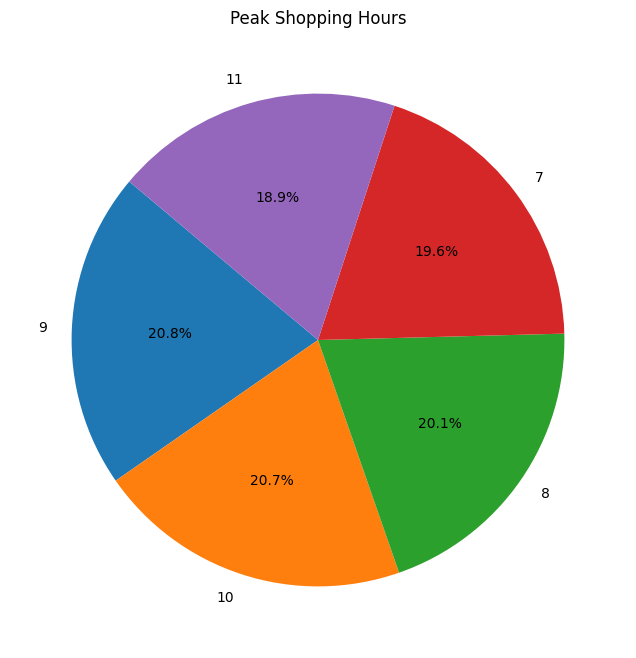

In [ ]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas for easier visualization
result_df = result.limit(5).toPandas()  # Select top 10 peak hours

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(result_df['purchase_count'], labels=result_df['hour'], autopct='%1.1f%%', startangle=140)
plt.title("Peak Shopping Hours")
plt.show()


## Top Selling Products

In [ ]:
result = spark.sql("""
  SELECT brand, product_id, COUNT(*) as purchase_count
  FROM ecommerce_data
  GROUP BY product_id, brand
  ORDER BY purchase_count DESC
  LIMIT 30
""")

result.show()


+-------+-------------------+--------------+
|  brand|         product_id|purchase_count|
+-------+-------------------+--------------+
|samsung|1515966223517846928|          2759|
|samsung|1515966223509106786|          2600|
|  apple|1515966223509088613|          2556|
|samsung|1515966223509088532|          2550|
|  apple|1515966223509088567|          2497|
|samsung|1515966223510174551|          2370|
|samsung|1515966223509088521|          2156|
|samsung|1515966223509104145|          2037|
|samsung|1515966223509088639|          1904|
|    ava|1515966223509088620|          1723|
|  apple|1515966223509088671|          1664|
|    ava|1515966223509089642|          1558|
|samsung|2273948227654910595|          1441|
|samsung|1515966223509089514|          1354|
|samsung|1515966223509089067|          1274|
|samsung|1515966223509088692|          1220|
|    ava|1515966223521756078|          1191|
|samsung|1515966223522710798|          1180|
|  apple|1515966223509553808|          1179|
|samsung|1

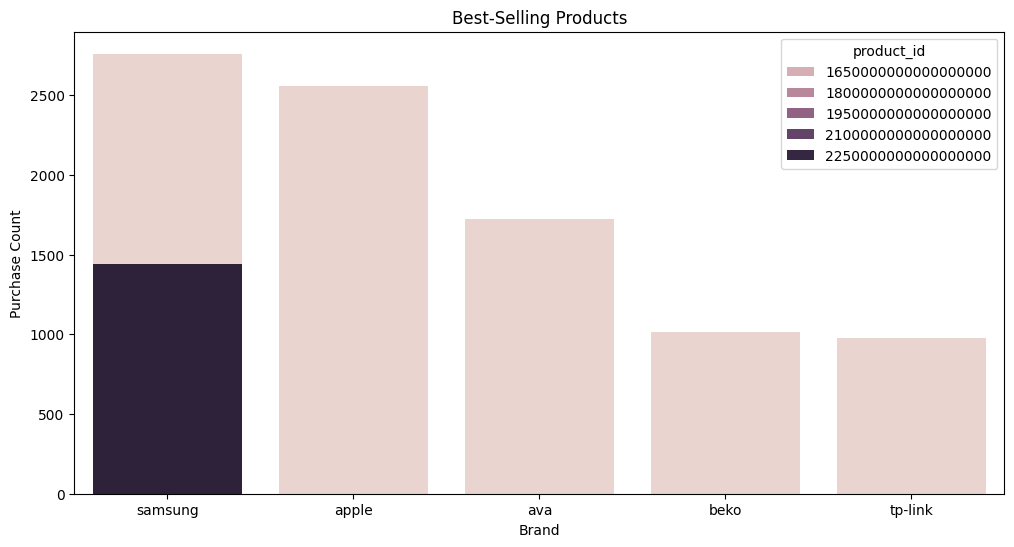

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas for visualization
top_products_df = result.toPandas()

# Set up the plot
plt.figure(figsize=(12, 6))
sns.barplot(x="brand", y="purchase_count", data=top_products_df, hue="product_id", dodge=False)

# Customize the plot
plt.title("Best-Selling Products")
plt.xlabel("Brand")
plt.ylabel("Purchase Count")

plt.show()

## Average Spending by Brand

In [ ]:
result = spark.sql("""
  SELECT brand, AVG(price) as avg_spending
  FROM ecommerce_data
  GROUP BY brand
  ORDER BY avg_spending DESC
  LIMIT 10
""")

result.show()

+----------+------------------+
|     brand|      avg_spending|
+----------+------------------+
| yamaguchi|           6215.25|
| technogym| 3674.898333333333|
|      gewa|           3261.78|
|     loewe|2321.5024999999996|
|    nvidia|           2218.65|
|   hitachi|2165.3228571428567|
|  liebherr|2105.7957142857144|
|      kona|1836.2166666666667|
|    casada|1546.7737837837842|
|waterrower|           1377.29|
+----------+------------------+



<ipython-input-32-af7cc55dbaf3>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg_spending", y="brand", data=avg_spending_df, palette="viridis")


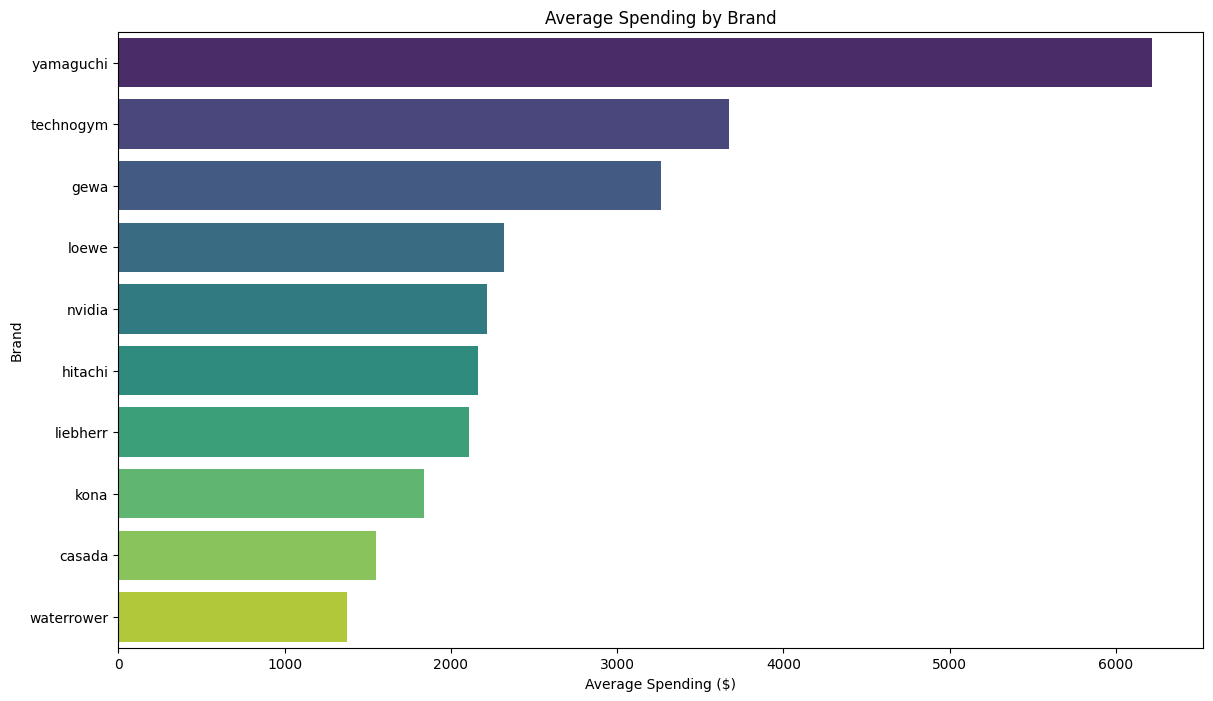

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas for plotting
avg_spending_df = result.toPandas()

# Plot the average spending by brand
plt.figure(figsize=(14, 8))
sns.barplot(x="avg_spending", y="brand", data=avg_spending_df, palette="viridis")

# Customize the plot
plt.title("Average Spending by Brand")
plt.xlabel("Average Spending ($)")
plt.ylabel("Brand")

plt.show()

## Product Popularity by Category

In [ ]:
result = spark.sql("""
  SELECT category_code, COUNT(*) as category_popularity
  FROM ecommerce_data
  GROUP BY category_code
  ORDER BY category_popularity DESC
  LIMIT 10
""")

result.show()

+--------------------+-------------------+
|       category_code|category_popularity|
+--------------------+-------------------+
|electronics.smart...|             102312|
|  computers.notebook|              25883|
|appliances.kitche...|              20047|
|electronics.audio...|              19805|
|electronics.video.tv|              17662|
|appliances.enviro...|              15942|
|appliances.kitche...|              14187|
|appliances.kitche...|              11909|
|computers.periphe...|              10166|
|furniture.kitchen...|               9700|
+--------------------+-------------------+



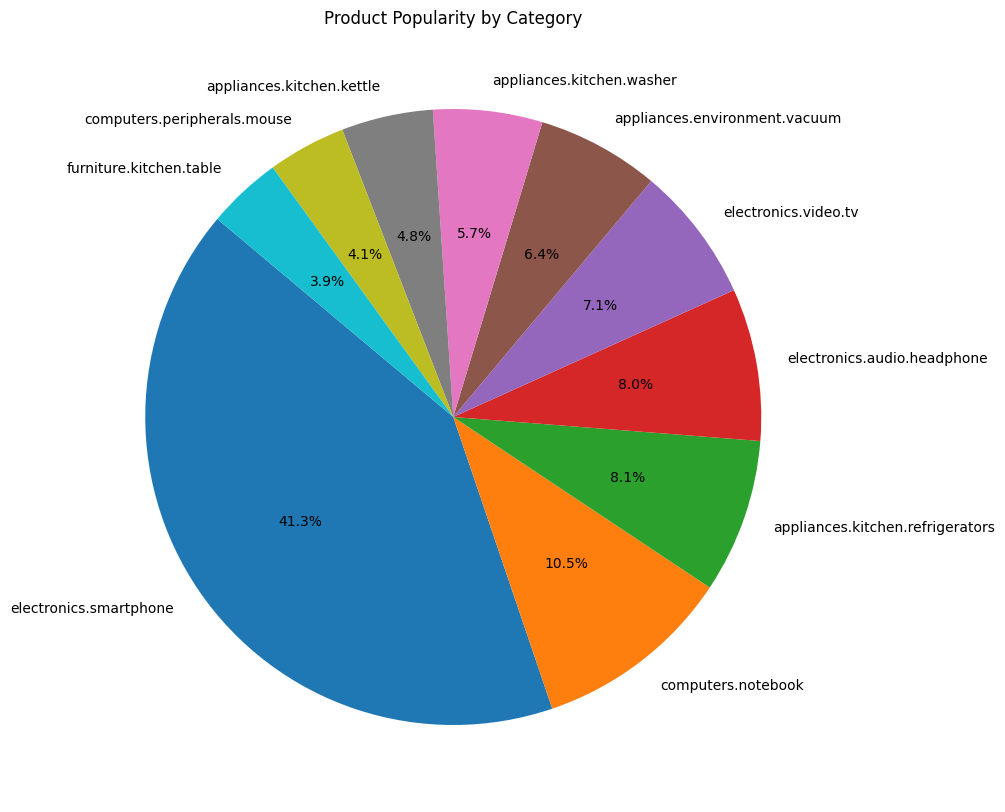

In [ ]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas for visualization
category_popularity_df = result.toPandas()

# Plot a pie chart
plt.figure(figsize=(10, 10))
plt.pie(category_popularity_df['category_popularity'], labels=category_popularity_df['category_code'], autopct='%1.1f%%', startangle=140)
plt.title("Product Popularity by Category")
plt.show()


High-Value Customers

In [ ]:
result = spark.sql("""
  SELECT user_id, SUM(price) as total_spending
  FROM ecommerce_data
  GROUP BY user_id
  ORDER BY total_spending DESC
  LIMIT 10
""")

result.show()

+-------------------+------------------+
|            user_id|    total_spending|
+-------------------+------------------+
|1515915625512854301| 68035.59999999998|
|1515915625505835892| 62115.18999999999|
|1515915625513809944|60182.199999999975|
|1515915625460303747| 51191.18999999997|
|1515915625456901629|          48753.19|
|1515915625510845934| 45797.88999999997|
|1515915625496634949| 44224.44999999999|
|1515915625492172027|          44038.32|
|1515915625513724906| 42359.57000000001|
|1515915625512438990| 42163.69999999999|
+-------------------+------------------+



Price Distribution Across Categories

In [ ]:
result = spark.sql("""
  SELECT category_code, MIN(price) as min_price, MAX(price) as max_price, AVG(price) as avg_price
  FROM ecommerce_data
  GROUP BY category_code
""")

result.show(10)

+--------------------+---------+---------+------------------+
|       category_code|min_price|max_price|         avg_price|
+--------------------+---------+---------+------------------+
|    computers.ebooks|    23.13|   481.46| 199.6687185929648|
|computers.periphe...|     6.92|  4259.24| 71.94989518506415|
|construction.tool...|     1.13|   104.14|18.212027306578413|
|appliances.kitche...|     18.5|   196.74| 43.29840694006309|
|electronics.video...|     9.24|  2314.79| 401.3619130434783|
|       apparel.shirt|    30.07|    32.38|31.898340425531988|
|electronics.camer...|    82.15|  3654.61| 670.2439849624059|
|electronics.audio...|     0.23|   810.16| 83.85927190103752|
|appliances.kitche...|   231.46|  1851.83| 491.1084141867109|
|appliances.kitche...|    16.18|   543.96|146.17186907020846|
+--------------------+---------+---------+------------------+
only showing top 10 rows



## Monthly Revenue Trends

In [ ]:
result = spark.sql("""
  SELECT YEAR(event_time) as year, MONTH(event_time) as month, SUM(price) as monthly_revenue
  FROM ecommerce_data
  GROUP BY year, month
  ORDER BY year, month
  LIMIT 10
""")

result.show()

+----+-----+--------------------+
|year|month|     monthly_revenue|
+----+-----+--------------------+
|1970|    1|  158231.46000000017|
|2020|    1|  1512733.1499999936|
|2020|    2|  1928107.4199999848|
|2020|    3|    2532486.75999996|
|2020|    4|   1550330.440000003|
|2020|    5|   7180919.010000027|
|2020|    6|   6834606.499999966|
|2020|    7|1.5112834930001142E7|
|2020|    8| 2.601872414000149E7|
|2020|    9|1.5713247590000922E7|
+----+-----+--------------------+



In [ ]:
result = spark.sql("""
  SELECT YEAR(event_time) as year, MONTH(event_time) as month, SUM(price) as monthly_revenue
  FROM ecommerce_data
  WHERE YEAR(event_time) = 2020
  GROUP BY year, month
  ORDER BY month
""")

result.show()


+----+-----+--------------------+
|year|month|     monthly_revenue|
+----+-----+--------------------+
|2020|    1|  1512733.1499999936|
|2020|    2|  1928107.4199999848|
|2020|    3|    2532486.75999996|
|2020|    4|   1550330.440000003|
|2020|    5|   7180919.010000027|
|2020|    6|   6834606.499999966|
|2020|    7|1.5112834930001142E7|
|2020|    8| 2.601872414000149E7|
|2020|    9|1.5713247590000922E7|
|2020|   10| 1.763243188000201E7|
|2020|   11|1.0753887050000735E7|
+----+-----+--------------------+



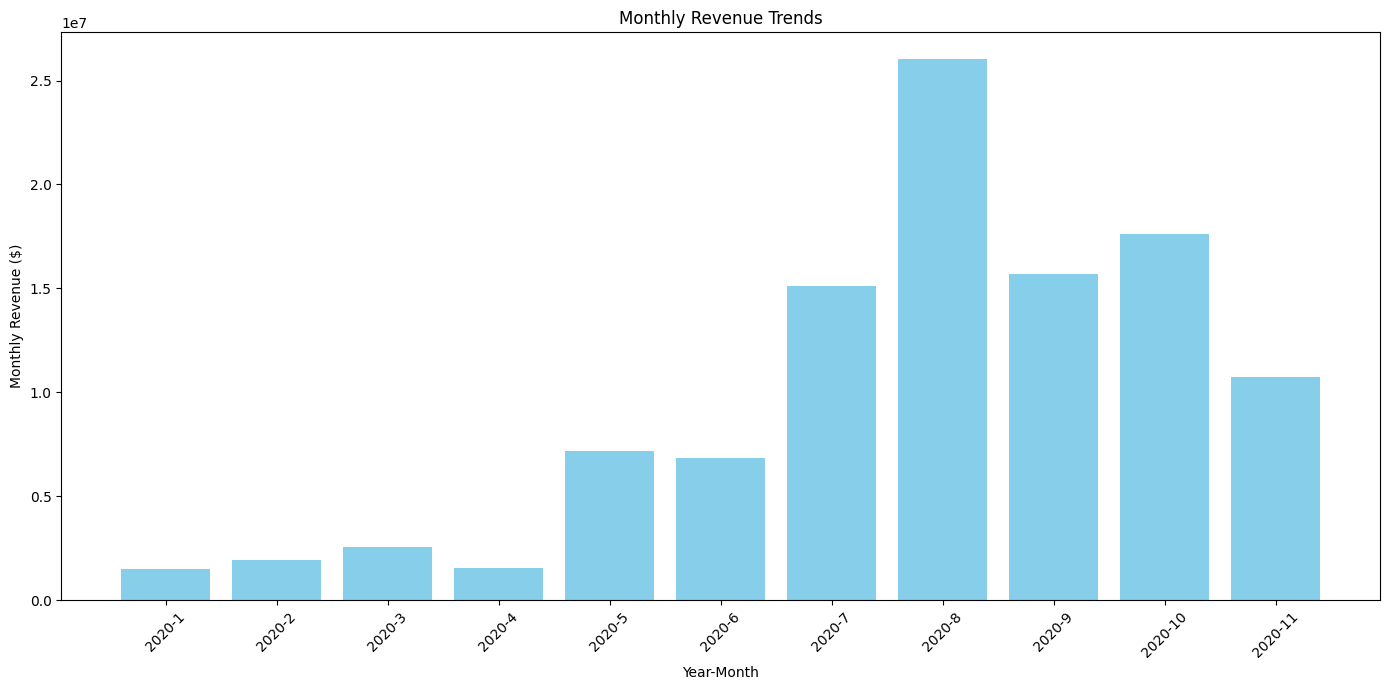

In [ ]:
# Convert Spark DataFrame to Pandas for plotting
monthly_revenue_df = result.toPandas()

# Combine the year and month columns into a single 'year_month' column
monthly_revenue_df['year_month'] = monthly_revenue_df['year'].astype(str) + '-' + monthly_revenue_df['month'].astype(str)

# Plot the column chart for monthly revenue
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.bar(monthly_revenue_df['year_month'], monthly_revenue_df['monthly_revenue'], color='skyblue')
plt.xlabel("Year-Month")
plt.ylabel("Monthly Revenue ($)")
plt.title("Monthly Revenue Trends")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Popular Products by Category

In [ ]:
result = spark.sql("""
SELECT category_code, product_id, COUNT(*) as purchase_count
FROM ecommerce_data
GROUP BY category_code, product_id
ORDER BY product_id, purchase_count DESC
LIMIT 10
""")

result.show()

+--------------------+-------------------+--------------+
|       category_code|         product_id|purchase_count|
+--------------------+-------------------+--------------+
|electronics.smart...|1515966223509088493|           417|
|       apparel.glove|1515966223509088496|           161|
|electronics.smart...|1515966223509088497|           424|
|electronics.smart...|1515966223509088498|           479|
|  computers.notebook|1515966223509088499|            78|
|appliances.person...|1515966223509088502|            22|
|electronics.audio...|1515966223509088503|            37|
|computers.periphe...|1515966223509088504|             5|
|appliances.enviro...|1515966223509088505|            18|
|electronics.audio...|1515966223509088506|           228|
+--------------------+-------------------+--------------+



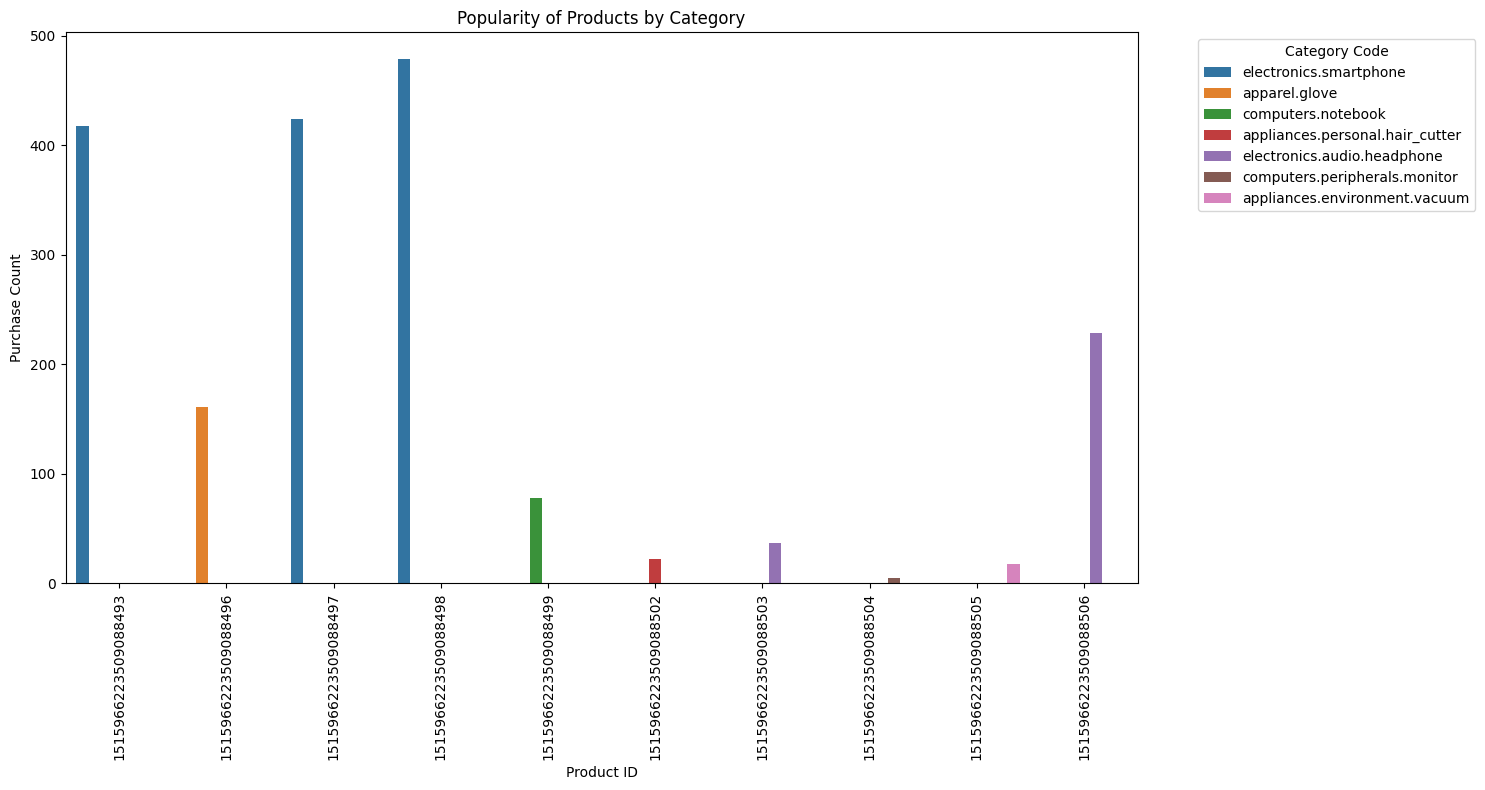

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Spark DataFrame to Pandas DataFrame
data_df = result.toPandas()

# Set up the figure
plt.figure(figsize=(15, 8))

# Use seaborn for a clearer grouped bar plot
sns.barplot(
    x='product_id', y='purchase_count', hue='category_code',
    data=data_df, dodge=True  # dodge=True to group bars by category
)

# Set plot labels and title
plt.xlabel("Product ID")
plt.ylabel("Purchase Count")
plt.title("Popularity of Products by Category")

# Rotate x-axis labels if they are too crowded
plt.xticks(rotation=90)

# Show plot
plt.legend(title="Category Code", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Cross-Category Shopping Patterns

In [ ]:
result = spark.sql("""
  SELECT user_id, COUNT(DISTINCT category_code) as category_count
  FROM ecommerce_data
  GROUP BY user_id
  HAVING category_count > 1
  ORDER BY category_count DESC
""")

result.show(10)

+-------------------+--------------+
|            user_id|category_count|
+-------------------+--------------+
|1515915625456901629|            40|
|1515915625443885349|            30|
|1515915625514704541|            29|
|1515915625445990176|            28|
|1515915625484623453|            27|
|1515915625454709354|            27|
|1515915625441849160|            27|
|1515915625442940349|            26|
|1515915625444090608|            25|
|1515915625484617788|            25|
+-------------------+--------------+
only showing top 10 rows



Average Order Value Over Time

In [ ]:
result = spark.sql("""
  SELECT YEAR(event_time) as year, MONTH(event_time) as month, AVG(price) as avg_order_value
  FROM ecommerce_data
  GROUP BY year, month
  ORDER BY year, month
""")

result.show(10)

+----+-----+------------------+
|year|month|   avg_order_value|
+----+-----+------------------+
|1970|    1|191.10079710144947|
|2020|    1|165.25378523049963|
|2020|    2|166.70477433857727|
|2020|    3|203.23302784687908|
|2020|    4| 176.0338866810495|
|2020|    5|232.95007493674257|
|2020|    6| 229.7346722689064|
|2020|    7|247.60120795584876|
|2020|    8|316.53719238912737|
|2020|    9|293.20683678231273|
+----+-----+------------------+
only showing top 10 rows



In [ ]:
result = spark.sql("""
  SELECT DATE(event_time) as date, MONTH(event_time) as month, AVG(price) as avg_order_value
  FROM ecommerce_data
  GROUP BY date
  ORDER BY date
""")

result.show(10)

+----------+-----+------------------+
|      date|month|   avg_order_value|
+----------+-----+------------------+
|1970-01-01|    1|191.10079710144947|
|2020-01-05|    1|169.95663341645886|
|2020-01-06|    1|144.74577956989245|
|2020-01-07|    1|151.98494714587724|
|2020-01-08|    1|161.05183946488293|
|2020-01-09|    1|160.72661631419942|
|2020-01-10|    1|182.66463888888882|
|2020-01-11|    1|147.13658536585368|
|2020-01-12|    1| 170.2197592592594|
|2020-01-13|    1|138.36529629629632|
+----------+-----+------------------+
only showing top 10 rows



In [ ]:
result = spark.sql("""
  SELECT user_id, COUNT(order_id) AS total_orders, SUM(price) AS total_spent
FROM ecommerce_data
GROUP BY user_id
ORDER BY total_spent DESC
LIMIT 10;
""")

result.show()

+-------------------+------------+------------------+
|            user_id|total_orders|       total_spent|
+-------------------+------------+------------------+
|1515915625512854301|          61| 68035.59999999998|
|1515915625505835892|         182| 62115.18999999999|
|1515915625513809944|          30|60182.199999999975|
|1515915625460303747|          42| 51191.18999999997|
|1515915625456901629|         145|          48753.19|
|1515915625510845934|          33| 45797.88999999997|
|1515915625496634949|          73| 44224.44999999999|
|1515915625492172027|         146|          44038.32|
|1515915625513724906|         155| 42359.57000000001|
|1515915625512438990|          28| 42163.69999999999|
+-------------------+------------+------------------+

